# Simple and Effective Text Matching with Richer Alignment Features
# 简单有效的文本匹配与丰富的对齐功能

# Abstract

# 摘要



In this paper, we present a fast and strong neural approach for general purpose text matching applications. We explore what is sufficient to build a fast and well-performed text matching model and propose to keep three key features available for inter-sequence alignment: original point-wise features, previous aligned features, and contextual features while simplifying all the remaining components. We conduct experiments on four well-studied benchmark datasets across tasks of natural language inference, paraphrase identification and answer selection. The performance of our model ison par with the state-of-the-art on all datasets with much fewer parameters and the inference speed is at least 6 times faster compared with similarly performed ones.

在本文中，我们提出了一种快速、强的神经网络方法用于通用文本匹配。我们探讨了构建一个快速且执行良好的文本匹配模型所需的条件，并建议保留三个用于序列间对齐的关键特性:原始点对齐特性、以前对齐的特性和上下文特性，同时简化其余所有组件。我们在四个经过充分研究的基准数据集上进行了实验，包括自然语言推理、释义识别和答案选择等任务。我们的模型在所有参数少得多的数据集上的性能与最先进的一致，推理速度至少比同样执行的快6倍。

# 1 Introduction

# 1介绍


Text matching is a core research area in natural language processing with a long history. In text matching tasks, a model takes two text sequences as input and predicts a category or a scala value indicating their relationship. A wide range of tasks, including natural language inference (also known as recognizing textual entailment) (Bowman et al., 2015; Khot et al., 2018), paraphrase identification (Wang et al., 2017), answer selection (Yang et al., 2015), and so on, can be seen as specific forms of text matching problems. Research on general purpose text matching algorithm is beneficial to a large number of relevant applications.

文本匹配是自然语言处理的一个核心研究领域，有着悠久的历史。在文本匹配任务中，模型接受两个文本序列作为输入，并预测表示它们之间关系的类别或scala值。范围广泛的任务，包括自然语言推断(也称为识别文本暗含)(Bowman et al.， 2015;(Khot et al.， 2018)、释义识别(Wang et al.， 2017)、答案选择(Yang et al.， 2015)等，可以看作是文本匹配问题的具体形式。对通用文本匹配算法的研究有利于大量相关应用。

Deep neural networks are the most popular choices for text matching nowadays. Semantic alignment and comparison of two text sequences are the keys in neural text matching. Many previous deep neural networks contain a single intersequence alignment layer. To make full use of this only alignment process, the model has to take rich external syntactic features or hand-designed alignment features as additional inputs of the alignment layer (Chen et al., 2017; Gong et al., 2018), adopt a complicated alignment mechanism (Wang et al., 2017; Tan et al., 2018), or build a vast amount of post-processing layers to analyze the alignment result (Tay et al., 2018b; Gong et al., 2018).

深度神经网络是目前最流行的文本匹配方法。两个文本序列的语义对齐和比较是神经网络文本匹配的关键。许多以前的深度神经网络包含一个单一的序列间对齐层。为了充分利用这一仅有的对齐过程，模型必须采用丰富的外部句法特征或手工设计的对齐特征作为对齐层的额外输入(Chen et al.， 2017;(Gong et al.， 2018)，采用复杂的对准机制(Wang et al.， 2017;或构建大量的后处理层来分析对齐结果(Tay et al.， 2018b;龚等，2018)。

More powerful models can be built with multiple inter-sequence alignment layers. Instead of making a prediction based on the comparison result of a single alignment process, a stacked model with multiple alignment layers maintains its intermediate states and gradually refines its predictions. However, suffering from inefficient propagation of lower-level features and vanishing gradients, these deeper architectures are harder to train. Recent works have come up with ways of connecting stacked building blocks including dense connection (Tay et al., 2018a; Kim et al., 2018) and recurrent neural networks (Liu et al., 2018), which strengthen the propagation of lower-level features and yield better results than those with a single alignment process.

可以使用多个序列间对齐层来构建更强大的模型。一个具有多个对齐层的堆叠模型不再基于单个对齐过程的比较结果进行预测，而是保持其中间状态并逐步改进其预测。然而，由于底层特性的低效传播和渐变的消失，这些更深层的架构更难训练。最近的工作提出了连接堆叠建筑块的方法，包括密集连接(Tay et al.， 2018a;(Kim et al.， 2018)和循环神经网络(Liu et al.， 2018)，它们增强了低层特征的传播，并产生比单一比对过程更好的结果。

This paper presents RE2, a fast and strong neural architecture with multiple alignment processes for general purpose text matching. We question the necessity of many slow components in text matching approaches presented in previous literature, including complicated multi-way alignment mechanisms, heavy distillations of alignment results, external syntactic features, or dense connections to connect stacked blocks when the model is going deep. These design choices slow down the model by a large amount and can be replaced by much more lightweight and equally effective ones. Meanwhile, we highlight three key components for an efficient text matching model. These components, which the name RE2 stands for, are previous aligned features (Residual vectors), original point-wise features (Embedding vectors), and contextual features (Encoded vectors). The remaining components can be as simple as possible to keep the model fast while still yielding strong performance.

提出了一种用于文本匹配的快速、强、多对齐的神经网络结构RE2。我们质疑在以前的文献中提出的文本匹配方法中许多缓慢组件的必要性，包括复杂的多路对齐机制、对齐结果的大量提取、外部语法特征，或者当模型深入时连接堆叠块的密集连接。这些设计选择大大降低了模型的速度，可以用更轻的、同样有效的方法来替代。同时，我们强调了一个有效的文本匹配模型的三个关键组件。RE2表示这些组件，它们是先前对齐的特征(剩余向量)、原始点方向特征(嵌入向量)和上下文特征(编码向量)。其余的组件可以尽可能简单地保持模型的快速，同时仍然产生强大的性能。

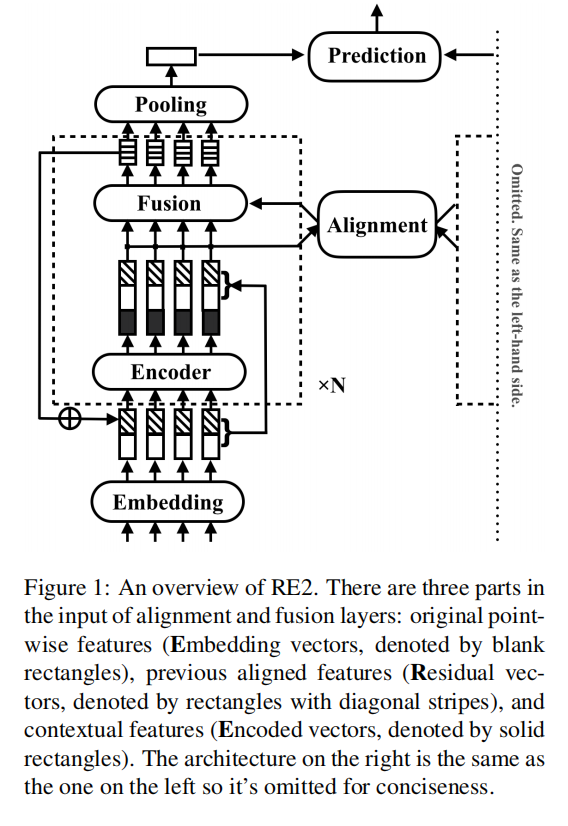

The general architecture of RE2 is illustrated in Figure 1. An embedding layer first embeds discrete tokens. Several same-structured blocks consisting of encoding, alignment and fusion layers then process the sequences consecutively. These blocks are connected by an augmented version of residual connections (see section 2.1). A pooling layer aggregates sequential representations into vectors which are finally processed by a prediction layer to give the final prediction. The implementation of each layer is kept as simple as possible, and the whole model, as a well-organized combination, is quite powerful and lightweight at the same time.

RE2的一般架构如图1所示。嵌入层首先嵌入离散的tokens。由编码层、对齐层和融合层组成的若干相同结构的块对序列进行连续处理。这些块通过增强版的残差连接进行连接(参见2.1节)。池化层将顺序表示聚合为向量，这些向量最终由预测层进行处理，以给出最终的预测。每一层的实现都尽可能地简单，整个模型作为一个组织良好的组合，同时非常强大和轻量级。

Our proposed method achieves the performance on par with the state-of-the-art on four benchmark datasets across three different tasks, namely SNLI and SciTail for natural language inference, Quora Question Pairs for paraphrase identification, and WikiQA for answer selection. Furthermore, our model has the least number of parameters and the fastest inference speed in all similarlyperformed models. We also conduct an ablation study to compare with alternative implementations of most components, perform robustness checks to see whether the model is robust to changes of structural hyperparameters, explore what roles the three key features in RE2 play by comparing their occlusion sensitivity and show the evolution of alignment results by a case study. We release the source code1 of our experiments for reproducibility and hope to facilitate future researches.

我们提出的方法在三个不同任务的四个基准数据集上实现了与最新水平相当的性能，即SNLI和SciTail用于自然语言推理，Quora问题对用于释义识别，WikiQA用于答案选择。在所有相似模型中，我们的模型参数最少，推理速度最快。我们也进行消融研究与替代大多数组件的实现,进行鲁棒性检查模型是否健壮的结构超参数变化,探索中的三个关键特性RE2扮演什么角色比较闭塞的敏感性和显示对齐的进化结果的案例研究。我们发布了我们的实验的源代码1的再现性，并希望促进未来的研究。

https://github.com/alibaba-edu/simple-effective-text-matching

# 2 Our Approach

# 2我们的方法



In this section, we introduce our proposed approach RE2 for text matching. Figure 1 gives anillustration of the overall architecture. Two textsequences are processed symmetrically before theprediction layer, and all parameters except thosein the prediction layer are shared between the twosequences. For conciseness, we omit the part forthe other sequence in the figure.

在本节中，我们将介绍我们提出的用于文本匹配的方法RE2。图1给出了总体架构的说明。两个文本序列在预测层之前进行对称处理，除预测层中的参数外的所有参数在两个序列之间共享。为了简洁，我们省略了图中其他序列的部分。



In RE2, tokens in each sequence are first embedded by the embedding layer and then processedconsecutively by N same-structured blocks withindependent parameters (dashed boxes in Figure 1) connected by augmented residual connections. Inside each block, a sequence encoder first computes contextual features of the sequence (solidrectangles in Figure 1). The input and output ofthe encoder are concatenated and then fed into analignment layer to model the alignment and interaction between the two sequences. A fusion layerfuses the input and output of the alignment layer. The output of the fusion layer is considered as theoutput of this block. The output of the last blockis sent to the pooling layer and transformed intoa fixed-length vector. The prediction layer takesthe two vectors as input and predicts the final target. The cross entropy loss is optimized to trainthe model in classification tasks.

在RE2中，每个序列中的tokens首先由嵌入层嵌入，然后由N个具有依赖参数的相同结构的块(图1中的虚线框)连续处理，这些参数由增强的残差连接。在每个块内部，序列编码器首先计算序列的上下文特征(图1中的实线矩形框)，将编码器的输入和输出连接起来，然后送入一个对齐层，对两个序列之间的对齐和交互进行建模。融合层融合对齐层的输入和输出。融合层的输出被认为是此块的输出。最后一个块的输出被发送到池层并转换为一个固定长度的向量。预测层以这两个向量作为输入，预测最终目标。优化交叉熵损失，对模型进行分类任务训练。

The implementation of each layer is kept as simple as possible. We use only word embeddingsin the embedding layer, without character embeddings or syntactic features. Vanilla multi-layer convolutional networks with same padding (Collobert et al., 2011) are adopted as the encoder. Recurrent networks are slower and do not leadto further improvements, so they are not adoptedhere. A max-over-time pooling operation (Collobert et al., 2011) is used in the pooling layer. The details of augmented residual connections andother layers are introduced as follows.

每一层的实现都尽可能的简单。我们只在嵌入层中使用单词嵌入，而不使用字符嵌入或语法特性。采用相同填充的香草多层卷积网络(Collobert et al.， 2011)作为编码器。循环网络比较慢，不会导致进一步的改进，所以在这里不采用。最大超时池操作(Collobert et al.， 2011)用于池化层。增加的剩余连接和其他层的详细介绍如下。

## 2.1 Augmented Residual Connections

## 2.1增强残差连接

To provide richer features for alignment processes,RE2 adopts an augmented version of residual connections to connect consecutive blocks. For a sequence of length l, We denote the input and outputof the n-th block as x^(n) = (x 1^(n), x2^(n), . . . , xl^(n))and o^(n) = (o1^(n), o2^(n), . . . , ol^(n)), respectively. Let o^(0) be a sequence of zero vectors. The input of the first block x^(1), as mentioned before, is the output of the embedding layer (denoted by blank rectangles in Figure 1). The input of the n-th block x^(n) (n ≥ 2), is the concatenation of the input of the first block x^(1) and the summation of the output of previous two blocks (denoted by rectangles with diagonal stripes in Figure 1):

为了给对齐过程提供更丰富的特性，RE2采用了增强版的残差连接来连接连续块。对于长度为L的序列，我们将第n个块的输入和输出表示为x^(n) = (x 1^(n)， x2^(n)，…， xL^(n)) 和o^(n) = (o1^(n) o2^(n),oL ^ (n))。设o^(0)是一个由0个向量组成的序列。第一个块的输入x ^(1),如前所述,嵌入的输出层(图1)用空白矩形。第n个块的输入x ^ (n) (n≥2),是第一个块的连接的输入x ^(1)和前两块的输出的总和(用图1中带有对角线条纹的矩形表示):

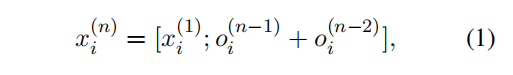

where [; ] denotes the concatenation operation.

(;]表示连接操作。

With augmented residual connections, there arethree parts in the input of alignment and fusionlayers, namely original point-wise features keptuntouched along the way (Embedding vectors),previous aligned features processed and refined byprevious blocks (Residual vectors), and contextualfeatures from the encoder layer (Encoded vectors). Each of these three parts plays a complementingrole in the text matching process.

在增强剩余连接的情况下，在对齐和融合层的输入中有三个部分，即原始的沿路径移动的点方向特征(嵌入向量)，由之前的块处理和细化的先前的对齐特征(剩余向量)，以及来自编码器层的上下文特征(编码向量)。这三个部分在文本匹配过程中都起到了补充作用。



## 2.2 Alignment Layer

## 2.2 对齐层



A simple form of alignment based on the attention mechanism is used following Parikh et al. (2016) with minor modifications. The alignment layer, as shown in Figure 1, takes features from the two sequences as input and computes the aligned representations as output. Input from the first sequence of length la is denoted as a = (a1, a2, . . . , ala) and input from the second sequence of length lb is denoted as b = (b1, b2, . . . , blb ). The similarity score eij between ai and bj is computed as the dot product of the projected vectors:

Parikh等人(2016)使用了一种基于注意机制的简单对齐形式，只做了少量修改。对齐层，如图1所示，从两个序列中提取特征作为输入，并计算对齐的表示作为输出。从第一个长度序列la输入记为a = (a1, a2，…，从长度lb的第二序列输入记为b = (b1, b2，…(blb)。ai与bj的相似度评分eij计算为投影向量的点积:

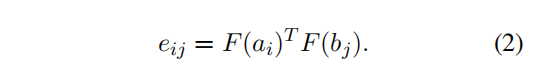

F is an identity function or a single-layer feedforward network. The choice is treated as a hyperparameter.

F是一个恒等函数或单层前馈网络。选择被视为超参数。



The output vectors a' and b' are computed by weighted summation of representations of the other sequence. The summation is weighted by similarity scores between the current position and the corresponding positions in the other sequence:

输出向量a'和b'是通过另一个序列的表示法的加权和计算出来的。求和由当前位置和其他序列中相应位置的相似度得分加权得到:

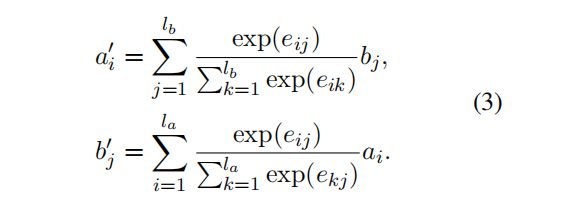

## 2.3 Fusion Layer

## 2.3融合层



The fusion layer compares local and aligned representations in three perspectives and then fuse themtogether. The output of the fusion layer for the firstsequence a¯ is computed by

融合层在三个透视图中比较本地和对齐的表示，然后将它们融合在一起。第一个序列a¯的融合层的输出由

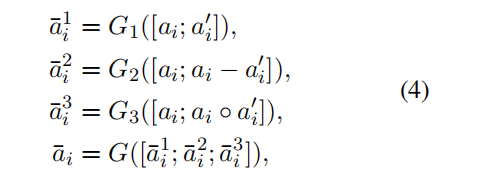

where G1, G2, G3, and G are single-layer feedforward networks with independent parametersand ◦ denotes element-wise multiplication. Thesubtraction operator highlights the difference between the two vectors while the multiplicationhighlights similarity. Formulations for b¯ are similar and omitted here.

其中G1、G2、G3和G为具有独立参数的单层前馈网络，◦则为元素明智的倍增。ubtraction算子强调了两个向量之间的差异，而乘法则强调了它们之间的相似性。b¯的公式是相似的，这里就省略掉了。



## 2.4 Prediction Layer

## 2.4预测层



The prediction layer takes the vector representations of the two sequences v1 and v2 from the pooling layers as input and predicts the final target following Mou et al. (2016):

预测层以池化层中v1和v2两个序列的向量表示为输入，预测Mou等(2016)之后的最终目标:

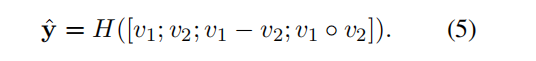

H is a multi-layer feed-forward neural network.In a classification task, yˆ ∈ RC represents the unnormalized predicted scores for all classes where C is the number of classes. The predicted classis yˆ = argmaxi yˆi. In a regression task, yˆ is thepredicted scala value.

H是一个多层前馈神经网络。在一个分类任务中,yˆ∈RC代表所有类的非规范预测成绩C类的数量。预测的长老监督会yˆ= argmaxi yˆ我。在回归任务中,yˆ分析scala的价值。



In symmetric tasks like paraphrase identification, a symmetric version of the prediction layeris used for better generalization:

在对称任务中，如释义识别，预测层的对称版本用于更好的概括:

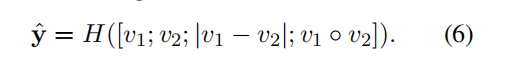

We also provide a simplified version of the prediction layer. Which version to use is treated asa hyperparameter. The simplified prediction layercan be expressed as:

我们还提供了预测层的简化版本。使用哪个版本作为超参数处理。简化的预测层可以表示为:

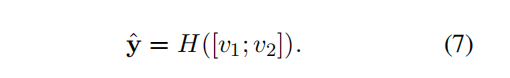


# 3 Experiments

# 3实验



## 3.1 Datasets

## 3.1数据集



In this section, we briefly introduce datasets usedin the experiments and their evaluation metrics.

在本节中，我们将简要介绍实验中使用的数据集及其评估指标。



SNLI (Bowman et al., 2015) (Stanford Natural Language Inference) is a benchmark dataset fornatural language inference. In natural languageinference tasks, the two input sentences are asymmetrical. The first one is called “premise” and thesecond is called “hypothesis”. The dataset contains 570k human annotated sentence pairs froman image captioning corpus, with labels “entailment”, “neutral”, “contradiction” and “-”. The “-”label indicates that the annotators cannot reach anagreement, so we ignore text pairs with this kindof labels in training and testing following Bowmanet al. (2015). We use the same dataset split as inthe original paper. Accuracy is used as the evaluation metric for this dataset.

SNLI (Bowman et al.， 2015) (Stanford Natural Language Inference)是一个自然语言推理的基准数据集。在自然语言推理任务中，两个输入句子是不对称的。第一个叫做“前提”，第二个叫做“假设”。该数据集包含57万对来自图像字幕语料库的人类注释句子对，标签为“entailment”、“neutral”、“矛盾性”和“-”。“-”标签表示标注者无法达成一致，因此在Bowmanet al.(2015)之后的培训和测试中，我们忽略了与此类标签的文本对。我们使用与原文相同的数据集分割。准确度作为该数据集的评估指标。



SciTail (Khot et al., 2018) (Science Entailment)is an entailment classification dataset constructedfrom science questions and answers. Since scientific facts cannot contradict with each other, thisdataset contains only two types of labels, entailment and neutral. We use the original dataset partition. This dataset contains 27k examples in total.10k examples are with entailment labels and theremaining 17k are labeled as neutral. Accuracy isused as the evaluation metric for this dataset.

SciTail (Khot et al.， 2018) (Science Entailment)是一个由科学问题和答案构成的隐含分类数据集。由于科学事实不能互相矛盾，这个数据集只包含两种类型的标签，隐含和中立。我们使用原始数据集分区。该数据集总共包含27k个示例。10k个例子使用了entailment标签，其余17k被标记为中性。准确度被用作这个数据集的评估指标。



Quora Question Pairs2is a dataset for paraphrase identification with two classes indicatingwhether one question is a paraphrase of the other. The dataset contains more than 400k real question pairs collected from Quora.com. We use thesame dataset partition as mentioned in Wang et al.(2017). Accuracy is used as the evaluation metricfor this dataset.

Quora Question pairs2是一个数据集的意译识别与两个类指示是否一个问题是另一个意译。数据集包含从Quora.com收集的40多万对真实问题对。我们使用Wang et al.(2017)中提到的相同的数据集分区。准确性被用作这个数据集的评估指标。



WikiQA (Yang et al., 2015) is a retrieval-basedquestion answering dataset based on Wikipedia. It contains questions and their candidate answers,with binary labels indicating whether a candidatesentence is a correct answer to the question it belongs to. This dataset has 20.4k training pairs,2.7k development pairs, and 6.2k testing pairs. Mean average precision (MAP) and mean reciprocal rank (MRR) are used as the evaluation metricsfor this task.

WikiQA (Yang et al.， 2015)是一个基于维基百科的基于检索的问答数据集。它包含问题和它们的候选答案，并用二进制标签表示候选语句是否属于问题的正确答案。这个数据集有20.4k的训练对、2.7k的开发对和6.2k的测试对。采用平均平均精度(MAP)和平均倒数秩(MRR)作为评价指标。



## 3.2 Implementation Details

## 3.2实现细节



We implement our model with TensorFlow (Abadiet al., 2016) and train on Nvidia P100 GPUs. Wetokenize sentences with the NLTK toolkit (Birdet al., 2009), convert them to lower cases andremove all punctuations. We do not limit themaximum sequence length, and all sequences ina batch are padded to the batch-wise maximum. Word embeddings are initialized with 840B-300dGloVe word vectors (Pennington et al., 2014) andfixed during training. Embeddings of out-ofvocabulary words are initialized to zeros and fixedas well. All other parameters are initialized with He initialization (He et al., 2015) and normalizedby weight normalization (Salimans and Kingma,2016). Dropout with a keep probability of 0.8is applied before every fully-connected or convolutional layer. The kernel size of the convolutional encoder is set to 3. The prediction layeris a two-layer feed-forward network. The hidden size is set to 150 in all experiments. Activations in all feed-forward networks are GeLU activations (Hendrycks and Gimpel, 2016), and weuse √2 as an approximation of the variance balancing parameter for GeLU activations in He initialization. We scale the summation in augmentedresidual connections by 1/√2 when n ≥ 3 to preserve the variance under the assumption that thetwo addends have the same variance.

我们使用TensorFlow (Abadiet al.， 2016)实现我们的模型，并在Nvidia P100 gpu上进行训练。使用NLTK工具包对句子进行Wetokenize (Birdet al.， 2009)，将它们转换为小写并删除所有标点符号。我们不限制最大的序列长度，所有序列在批处理中被填充到最大的批处理。Word embeddings使用840B-300dGloVe Word vector初始化(Pennington et al.， 2014)，并在培训期间固定。词汇表之外的词的嵌入被初始化为零，同时也被固定。所有其他参数初始化(He et al.， 2015)，并通过权重归一化(Salimans和Kingma,2016)进行归一化。在每一个全连接层或卷积层之前应用保留概率为0.8的Dropout。卷积编码器的内核大小设置为3。预测层是一个两层前馈网络。在所有实验中，隐藏的大小被设置为150。所有前馈网络中的激活都是GeLU激活(Hendrycks和Gimpel, 2016)，我们使用√2作为初始化时GeLU激活的方差平衡参数的近似值。当n≥3时，我们对增强对偶连接的总和乘以1/√2，以在两个加数方差相同的前提下保持方差。



The number of blocks is tuned in a range from 1 to 3. The number of layers of the convolutionalencoder is tuned from 1 to 3. Although in robustness checks (Table 7) we validate with up to 5 blocks and layers, in all other experiments wedeliberately limit the maximum number of blocksand number of layers to 3 to control the size of themodel. We use the Adam optimizer (Kingma and Ba, 2015) and an exponentially decaying learningrate with a linear warmup. The initial learning rateis tuned from 0.0001 to 0.003. The batch size istuned from 64 to 512. The threshold for gradientclipping is set to 5. For all the experiments exceptfor the comparison of ensemble models, we reportthe average score and the standard deviation of 10runs.

块的数量在1到3之间进行调整。convolutionalencoder的层数从1调整为3。虽然在鲁棒性检查(表7)中，我们验证最多5个块和层，但在所有其他实验中，我们故意限制最大块数和层数为3，以控制模型的大小。我们使用Adam优化器(Kingma和Ba, 2015)和线性预热的指数衰减学习机。初始学习速率从0.0001调整到0.003。批大小从64调整到512。渐变裁剪的阈值设置为5。对于所有的实验，除了集成模型的比较，我们报告了平均得分和10分的标准差。



## 3.3 Results on Natural Language Inference

## 3.3自然语言推理结果

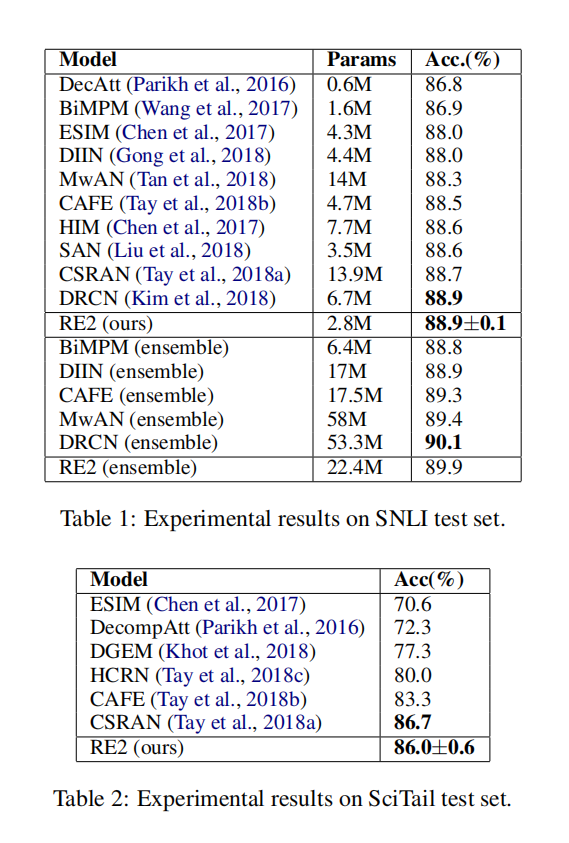

Results on SNLI dataset are listed in Table 1. Wecompare single models and ensemble models. Fora fair comparison, we only compare with resultsobtained without external contextualized embeddings. In the ensemble experiment, we train 8models with different random seeds and ensemblethe results by a voting strategy.

SNLI数据集的结果如表1所示。我们可以分为单模型和集成模型。为了公平的比较，我们只比较没有外部上下文嵌入的resultsob。在集成实验中，我们用不同的随机种子训练8个模型，并通过投票策略来固定结果。



Our method obtains a result on par with thestate-of-the-art among single models and a highlycompetitive result among ensemble models, withonly a few parameters. Compared to SAN, ourmodel reduces 20% parameters while improvesthe performance by 0.3% in accuracy, which indicates that our proposed architecture is highly ef-ficient.

我们的方法在只有少数几个参数的情况下，在单个模型中得到了与最先进模型相当的结果，在集成模型中得到了具有高度竞争力的结果。与SAN相比，我们的模型减少了20%的参数，同时提高了0.3%的精度，这表明我们提出的体系结构是高度有效的。



Results on Scitail dataset are listed in Table 2. The performance of our method is very close tostate-of-the-art. This dataset is considered muchmore difficult with fewer training data availableand generally low accuracy as a binary classification problem. The variance of the results is largersince the size of training and test set is only 4%and 20% compared to those of SNLI.

Scitail数据集的结果如表2所示。我们的方法的性能非常接近目前的水平。作为一个二分类问题，由于可用的训练数据较少且精度普遍较低，因此该数据集被认为更加困难。由于训练和测试集的规模仅为SNLI的4%和20%，因此结果的方差较大。



## 3.4 Results on Paraphrase Identification

## 3.4释义识别结果

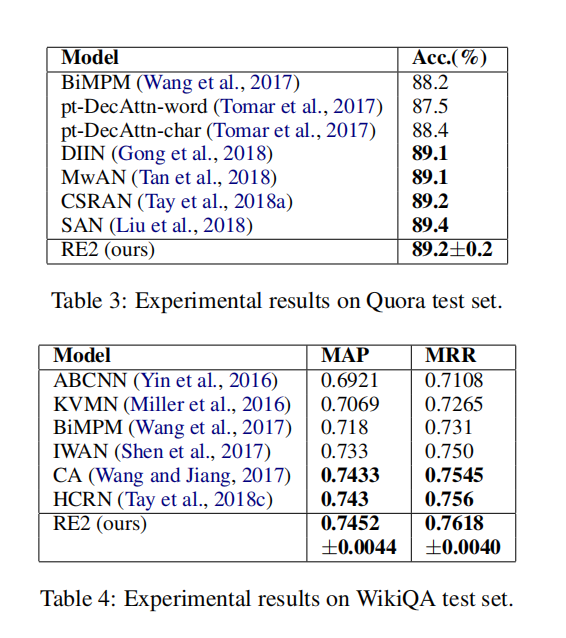

Results on Quora dataset are listed in Table 3. Since paraphrase identification is a symmetric taskwhere two input sequences can be swapped withno effect to the label of the text pair, in hyperparameter tuning we validate between two symmetric versions of the prediction layer (Equation 6 and Equation 7) and use no additional data augmentation. The performance of RE2 is on par with thestate-of-the-art on this dataset.

表3列出了Quora数据集上的结果。由于释义识别是一个对称的任务，其中两个输入序列可以交换而不影响文本对的标签，在超参数调优中，我们在预测层的两个对称版本(方程6和方程7)之间进行验证，并且不使用额外的数据扩充。RE2的性能与这个数据集上的最新技术相当。



## 3.5 Results on Answer Selection

## 3.5选择答案的结果



Results on WikiQA dataset are listed in Table 4. Note that some of the previous methods roundtheir reported results to three decimal points, butwe choose to align with the original paper (Yanget al., 2015) and round our results to four decimalpoints. In hyperparameter tuning, we choose thebest hyperparameters including early stopping according to MRR on WikiQA development set. Weobtain a result on par with the state-of-the-art reported on this dataset. It’s worth mentioning thatwe still train our model by point-wise binary classification loss, unlike some of the previous methods (including HCRN) which are trained by thepairwise ranking loss. Our method can performwell in the answer selection task without any taskspecific modifications.

表4列出了WikiQA数据集的结果。请注意，以前的一些方法将报告的结果四舍五入到三个小数点，但我们选择与原始论文保持一致(Yanget al.， 2015)，并将我们的结果四舍五入到四个小数点。在超参数调优中，我们根据WikiQA开发集上的MRR选择最佳超参数，包括提前停止。我们得到的结果与该数据集上报告的最新水平相当。值得一提的是，我们仍然通过点向分类损失来训练我们的模型，不像以前的一些方法(包括HCRN)是通过两两分类损失来训练的。我们的方法可以很好地完成答案选择任务，而不需要任何特定于任务的修改。



## 3.6 Inference Time

## 3.6推理时间

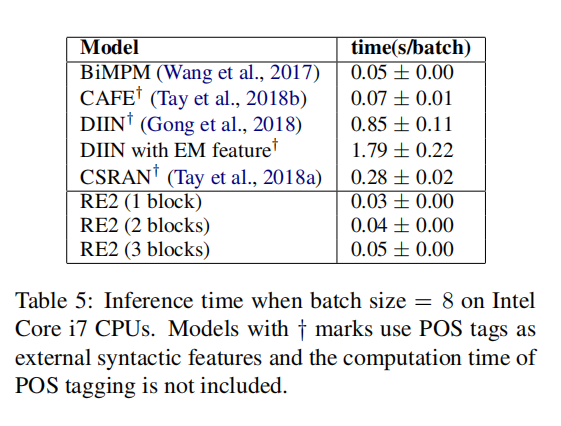

To show the efficiency of our proposed model, wecompare the inference time with some other models whose code is open-source. Table 5 showsthe comparison results. All the compared models are implemented in TensorFlow in the originalimplementations. The † mark indicates that themodel uses POS tags as external syntactic featuresand the computation time of POS tagging is notincluded. In our RE2 model, the number of en-coder layers is set to 3, the largest possible number in all previously reported experiments. Besides, since all the reported results of our proposedmethod are obtained with no more than 3 blocks,we only measure the inference time of RE2 with1-3 blocks. We train all the compared models using the official training code and commands released by the authors on Nvidia P100 GPUs andsave model checkpoints to disk. After training, allthe models are required to make predictions for abatch of 8 pairs of sentences on a MacBook Prowith Intel Core i7 CPUs. The lengths of these sentences are 20 and the maximum number of characters in a word is 12. The reported statistics are theaverage and the standard deviation of processing 100 batches.

为了说明我们所提出的模型的有效性，我们将其推理时间与其他一些代码是开源的模型进行比较。表5给出了比较结果。所有比较的模型都在原始实现的TensorFlow中实现。†标记表明模型使用POS标签作为外部语法特征，不包括POS标签的计算时间。在我们的RE2模型中，编码器层的数量被设置为3，这是所有先前报道的实验中最大的可能数量。此外，由于我们所提出的方法的所有报告结果都是在不超过3个block的情况下得到的，我们只测量了RE2的推理时间，其中有1-3个block。我们使用作者在Nvidia P100 gpu上发布的官方训练代码和命令训练所有比较的模型，并将模型检查点保存到磁盘。经过培训后，所有的模型都需要在一台配备英特尔酷睿i7处理器的MacBook pro笔记本电脑上预测8对句子。这些句子的长度为20，一个单词的最大字符数为12。报告的统计数据是加工100批的平均值和标准差。



The comparison results in Table 5 show thatour method has very high CPU inference speed,even with multiple stacked blocks. Comparedwith similarly performed methods, ours is 6 timesfaster than CSRAN and at least 17 times fasterthan DIIN. With the highly efficient design, ourmethod can perform well without any strong butslow building blocks like recurrent neural networks, dense connections or any syntactic features. Compared with models of similar inferencespeed, BiMPM and CAFE, ours obtains muchhigher prediction scores according to Table 1, Table 2, Table 3 and Table 4.

表5中的比较结果表明，我们的方法具有非常高的CPU推理速度，即使有多个堆叠的块。与类似的执行方法相比，我们的方法比CSRAN快6倍，比DIIN至少快17倍。通过高效的设计，我们的方法可以很好地执行，而不需要像递归神经网络、密集连接或任何语法特征这样的强而慢的构建块。与类似推理模型peed、BiMPM、CAFE相比，我们的预测得分更高，如表1、表2、表3、表4所示。



In summary, our proposed method achieves performance on par with the state-of-the-art on allfour well-studied datasets across three differenttasks with only a few parameters and fast inference speed.

综上所述，我们所提出的方法在三个不同的任务中，仅使用很少的参数和快速的推断速度，就可以在所有四个经过充分研究的数据集上取得与最新水平相当的性能。



## 3.7 Analysis

## 3.7分析

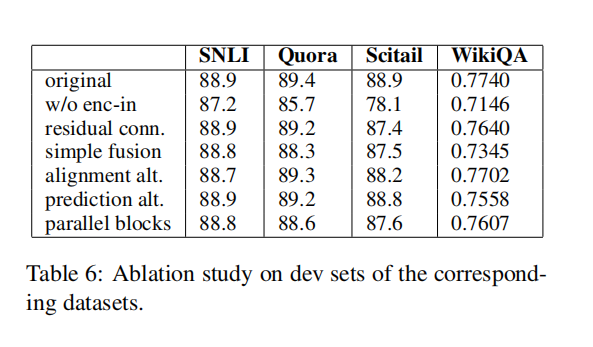

Ablation study. We present an ablation study ofour model, comparing the original model with 6ablation baselines: (1) “w/o enc-in”: use directlythe output of the encoder as the input of the alignment and fusion layers like in most previous approaches without concatenating the encoder input;(2) “residual conn.”: use vanilla residual connections (xi^(n) = oi^(n-1) +oi^(n-2)) in place of the augmented version; (3) “simple fusion”: use simply a¯i = G1([ai; ai']) and b¯i = G1([bi; bi']) as the fusion layer; (4) “alignment alt.”: use the alternativeversion of the alignment layer where F in Equation 2 is a single-layer feed-forward network or anidentity function; (5) “prediction alt.”: use the alternative version (Equation 5/6 or Equation 7) ofthe prediction layer; (6) parallel blocks: feed theembeddings directly to all the blocks and sum uptheir outputs as the input of the pooling layer instead of processing input sequences consecutivelyby each block. The last setting is designed to studywhether the improvement is due to deeper architecture or just a larger amount of parameters.

烧蚀研究。临近,我们提出一个消融研究模型,比较原始模型和6消融基线:(1)“w / o enc-in”:使用directlythe编码器的输出作为输入的对齐和融合层最喜欢在之前没有连接编码器的输入方法;(2)“剩余康涅狄格州。”:使用香草剩余连接(xi ^ (n) = oi ^ (n - 1) + oi ^ (n - 2))的增强版本;(3)“简单融合”:简单地用一个¯i = G1([ai;ai’)和b¯i = G1([bi;bi'])作为融合层;(4)“换向换向”:利用换向换向层，其中式(2)中的F为单层前馈网络或无恒等函数;(5)“预测alt”:使用预测层的备选版本(公式5/6或公式7);(6)并行块:将嵌入项直接提供给所有块，并将它们的输出相加作为池层的输入，而不是按每个块连续处理输入序列。最后一个设置用于研究改进是由于更深入的体系结构还是由于更多的参数。

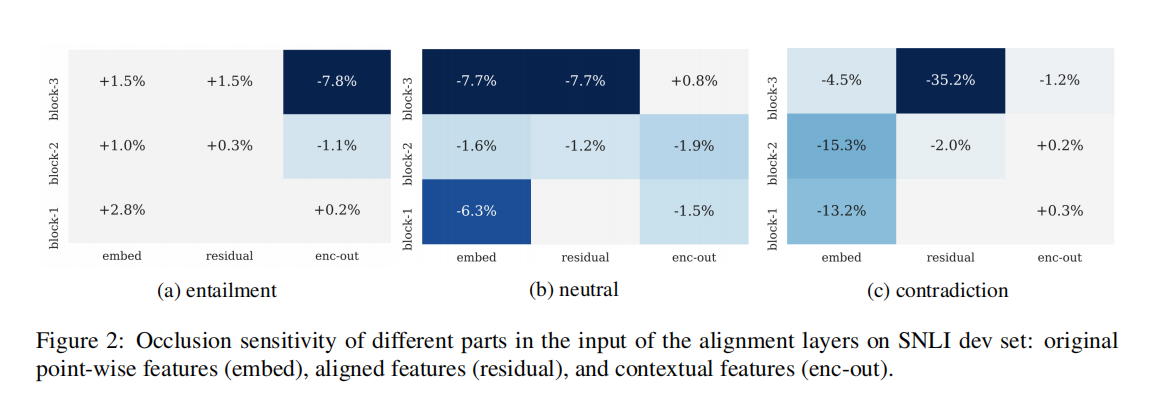

The ablation study is conducted on the development set of SNLI, Quora, Scitail, and WikiQA. InWikiQA we choose MRR as the evaluation metric. Note that on SciTail, F in Equation 2 in alignmentlayers is an identity function while on all otherdatasets F is a single-layer feed-forward network. On WikiQA, the simplified version (Equation 7)is used as the prediction layer while on all otherdatasets the full version (Equation 5 or 6) is used. The reported results are the average of 10 runs andthe standard deviations are omitted for clarity.

消融研究是在SNLI、Quora、Scitail和WikiQA的开发平台上进行的。在维基百科中，我们选择MRR作为评价指标。请注意，在SciTail中，校准层中公式2中的F是一个恒等函数，而在所有其他数据集上F是一个单层前馈网络。在WikiQA上，简化版本(方程7)用作预测层，而在所有其他数据集上，则使用完整版本(方程5或6)。报告的结果是10次运行的平均值，为了清楚起见，省略了标准差。

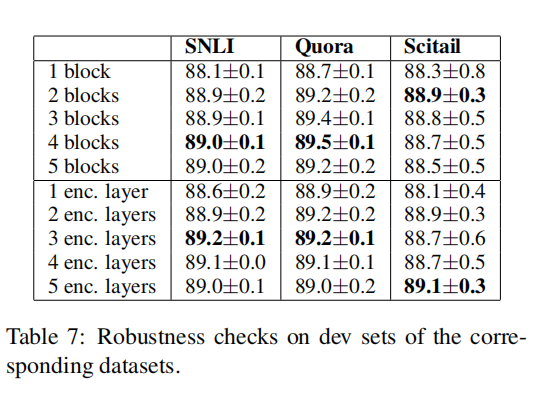

The result is shown in Table 6. The first ablation baseline shows that without richer features as the alignment input, the performance on all datasets degrades significantly. This is the key component in the whole model. The results of the second baseline show that vanilla residual connections without direct access to the original pointwise features are not enough to model the relations in many text matching tasks. The simpler implementation of the fusion layer leads to evidently worse performance, indicating that the fusion layer cannot be further simplified. On the other hand, the alignment layer and the prediction layer can be simplified on some of the datasets. In the last ablation study, we can see that parallel blocks perform worse than stacked blocks,which supports the preference for deeper model sover wider ones.

结果如表6所示。第一个消融基线显示，如果没有更丰富的特征作为比对输入，所有数据集的性能都会显著下降。这是整个模型的关键部分。第二个基线的结果表明，没有直接访问原始点态特征的普通残差连接不足以在许多文本匹配任务中对关系进行建模。融合层的实现越简单，性能越差，说明融合层不能进一步简化。另一方面，在某些数据集上，对齐层和预测层可以简化。在最近的消融研究中，我们可以看到并行块的性能比堆叠块差，这支持了对更深层模型的偏好而不是更广泛的模型。



Robustness checks. To check whether our proposed method is robust to different variants of structural hyperparameters, we experiment with (1) the number of blocks varying from 1 to 5 with the number of encoder layers set to 2; (2) the number of encoder layers varying from 1 to 5 with the number of blocks set to 2. Robustness checks are performed on the development set of SNLI, Quora and Scitail. The result is presented in Table 7. We can see in the table that fewer blocks or layers may not be sufficient but adding more blocks or layers than necessary hardly harms the performance. On WikiQA dataset, our method does not seem to be robust to structural hyperparameter changes. Crane (2018) mentions that on WikiQA dataset a neural matching model (Severyn and Moschitti, 2015) trained with different random seeds can result in differences up to 0.08 in MAP and MRR. We leave the further investigation of the high variance on the WikiQA dataset for further work.

鲁棒性检查。为了检验我们提出的方法是否对结构超参数的不同变量具有鲁棒性，我们对(1)进行了如下实验:(1)编码层数设置为2，块数从1到5变化;(2)编码器层数从1到5，块数设置为2。对SNLI、Quora和Scitail的开发集进行了鲁棒性检查。结果如表7所示。从表中可以看出，更少的块或层可能还不够，但是添加更多的块或层几乎不会影响性能。在WikiQA数据集上，我们的方法似乎对结构超参数变化不具有健壮性。Crane(2018)提到在WikiQA数据集上，使用不同的随机种子训练的神经匹配模型(Severyn and Moschitti, 2015)会导致MAP和MRR的差异高达0.08。我们把对WikiQA数据集的高方差的进一步研究留到以后做进一步的工作。



Occlusion sensitivity. To better understandwhat roles the three alignment features play, weperform an analysis of occlusion sensitivity similar to those in computer vision (Zeiler and Fergus, 2014). We use a three-block RE2 model topredict on SNLI dev set, mask one feature in oneblock to zeros at a time and report changes in accuracy of the three categories: entailment, neutral and contradiction. Occlusion sensitivity canhelp to reveal how much the model depends oneach part when deciding on a specific categoryand we can make some speculations about how themodel works based on the observations. Figure 2shows the result of occlusion sensitivity. Previousaligned features are absent in the first block andthus left blank.

闭塞的敏感度。为了更好地理解这三个对齐特征所起的作用，我们对遮挡敏感性进行了类似于计算机视觉的分析(Zeiler和Fergus, 2014)。我们使用一个三块RE2模型在SNLI开发集上进行预测，将一个块中的一个特性一次掩码为零，并报告三个类别的准确性变化:隐含、中性和矛盾。当决定一个特定的分类时，遮挡敏感性可以帮助揭示模型在多大程度上依赖于每个部分，并且我们可以基于观察对模型如何工作做出一些推测。图2显示了遮挡敏感性的结果。前对齐的特征在第一个块中不存在，因此留下空白。



The text matching process can be abstracted,with moderate simplifications, to three stages:aligning tokens between the two sequences, focusing on a subset of the aligned pairs, discerningthe semantic relations between the attended pairs. Each of the three key features in RE2 has a closerconnection with one of the stages.

文本匹配过程可以抽象为三个阶段，并进行适当的简化:在两个序列之间对标记进行对齐，关注对齐的对的子集，识别参与的对之间的语义关系。RE2中的三个关键特性都与其中一个阶段有密切的联系。



As we can see in Figure 2a, contextual features,represented by the output of the encoder, are indispensable when predicting entailment. These features connect with the first stage of text matching. The sequence encoder, implemented by convolutional networks, models local and phrase-level semantics, which helps to build correct alignmentfor each position. For example, consider the pair “A red car is next to a green house” and “A redcar is parked near a house”. If the noun phrasesin the two sentences are not correctly modeled bythe contextual encoding and “green” is incorrectlyaligned with another color word “red”, the pairlooks much less like entailment.

如图2a所示，在预测隐含时，由编码器的输出所表示的上下文特征是必不可少的。这些特性与文本匹配的第一阶段有关。序列编码器由卷积网络实现，为本地和短语级语义建模，这有助于为每个位置建立正确的对齐。例如，考虑“一辆红色的车在一所绿色的房子旁边”和“一辆红色的车停在一所房子旁边”。如果两个句子中的名词短语没有通过上下文编码正确地建模，并且“green”与另一个颜色词“red”不正确地对齐，那么这对组合看起来就不太像暗含。



In Figure 2b and Figure 2c, we can see thatlacking direct access of previous aligned features(residual vectors), especially in the final block, results in significant degradation when predictingneutral and contradiction. Previous aligned features are related to the second stage of focusing ona subset of the aligned pairs. Without correct focus, the model may ignore non-entailing pairs andattend to other trivially aligned and semanticallymatched pairs, which results in failure in predicting neutral and contradiction. The importance ofeach position can be distilled and stored in previous aligned features and helps the model to focusin latter blocks.

在图2b和图2c中，我们可以看到，由于缺乏对之前对齐的特征(残差向量)的直接访问，特别是在最后一个块中，当预测中性和矛盾时，会导致显著的退化。先前的对齐特征与聚焦对齐对子集的第二阶段相关。如果没有正确的焦点，模型可能会忽略不带齿的对，而关注其他平凡对齐和语义匹配的对，这将导致预测中性和矛盾的失败。每个位置的重要性可以被提取并存储在之前的对齐特性中，并帮助模型集中到后面的块中。



We can conclude from Figure 2b and Figure2c that when original point-wise features represented by embedding vectors are not directly accessible by alignment layers and fusion layers, themodel is struggling to predict neutral and contradiction correctly. Original point-wise featuresconnect with the final stage where semantic differences between aligned pairs are compared. Intact point-wise representations of the aligned pairsfacilitate the model in the comparison of their semantic differences, which plays a vital role in predicting neutral and contradiction.

从图2b和图2c可以看出，当嵌入向量所代表的原始点方向特征不能被对齐层和融合层直接访问时，模型很难正确预测中性和矛盾。最初的逐点特性连接到最后一个阶段，在这个阶段比较对齐对之间的语义差异。对齐对的完整点表示有助于比较它们的语义差异，这对预测中性和矛盾起着至关重要的作用。



Case study. We present a case study of ourmodel to show how inter-sequence alignment results evolve in our stacked architecture. An example pair of sentences are chosen from the development set of the SNLI dataset. The premise is “Agreen bike is parked next to a door”, and the hypothesis is “The bike is chained to the door”. Figure 3 shows the visualization of the attention distribution (normalized eij in Equation 3) in alignment layers of the first and the last blocks.

案例研究。我们对我们的模型进行了一个案例研究，以展示在我们的堆叠架构中序列间对齐结果是如何演变的。从SNLI数据集的开发集中选择一对句子作为示例。前提是“绿色自行车停在门旁边”，假设是“自行车拴在门上”。图3显示了在第一个和最后一个块的对齐层中注意分布(公式3中的标准化eij)的可视化。



In the first block, the alignment results are almost word- or phrase-level. “parked next to” is associated mostly with “bike” and “door” since thereis a weaker direct connection between “parked”and “chained”. In the final block, the alignment results take consideration of the semantics and structures of the whole sentences. The word “parked”is strongly associated with “chained” and “next to”is aligned with “to the” following “chained”. Withcorrect alignment, the model is able to tell that although most parts in the premise entail the alignedparts in the hypothesis, “parked” does not entail“chained”, so it correctly predicts that the relationbetween the two sentences is neutral. Our modelkeeps the lower-level alignment results as intermediate states and gradually refines them to higherlevel ones.

在第一个块中，对齐结果几乎是单词或短语级的。“next to”通常与“bike”和“door”联系在一起，因为“parking”和“chained”之间的直接联系要弱一些。在最后一个块中，对齐结果考虑了整个句子的语义和结构。单词“”与“chained”联系紧密，而“next to”与“following”联系紧密。通过正确的对齐，该模型能够判断出，虽然前提中的大部分部分都包含了假设中的对齐部分，但是“parking”并不包含“chained”，所以它正确地预测出了这两个句子之间的关系是中性的。我们的模型将较低层次的对齐结果作为中间状态，并逐步将其细化为较高层次的结果。

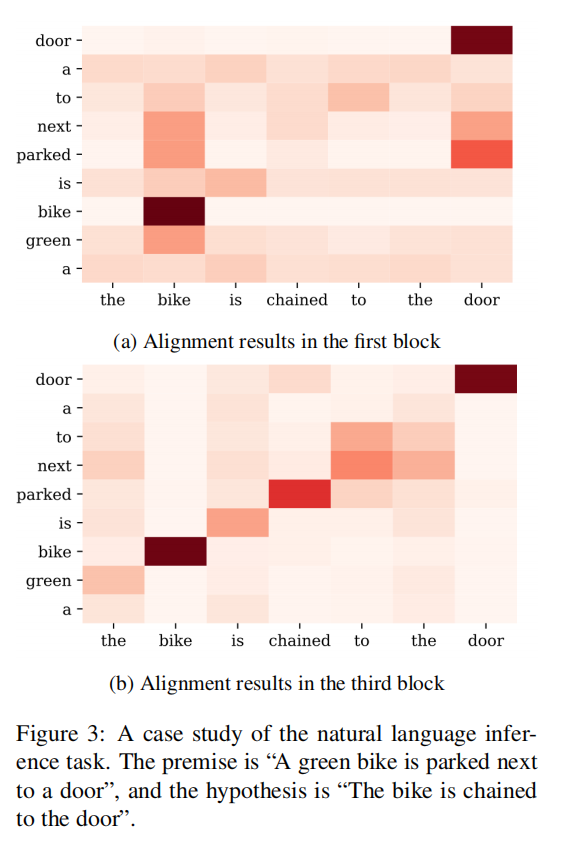

# 4 Related Work

# 4相关工作



Deep neural networks are dominant in the textmatching area. Semantic alignment and comparison between two text sequences lie in the core oftext matching. Early works explore encoding eachsequence individually into a vector and then building a neural network classifier upon the two vectors. In this paradigm, recurrent (Bowman et al.,2015), recursive (Tai et al., 2015) and convolutional (Yu et al., 2014; Tan et al., 2016) networksare used as the sequence encoder. The encoding ofone sequence is independent of the other in thesemodels, making the final classifier hard to modelcomplex relations.

深度神经网络在文本匹配领域占主导地位。两个文本序列之间的语义对齐和比较是文本匹配的核心。早期的工作探索将每个序列单独编码成一个向量，然后在这两个向量上构建一个神经网络分类器。在这个范式中，是递归(Bowman et al.，2015)、递归(Tai et al.，2015)和卷积(Yu et al.， 2014);Tan等人，2016)使用网络作为序列编码器。在这些模型中，一个序列的编码是独立于另一个序列的，这使得最终的分类器很难对复杂的关系建模。



Later works, therefore, adopt the matching aggregation framework to match two sequences atlower levels and aggregate the results based on theattention mechanism. DecompAtt (Parikh et al.,2016) uses a simple form of attention for alignment and aggregate aligned representations withfeed-forward networks. ESIM (Chen et al., 2017)uses a similar attention mechanism but employsbidirectional LSTMs as encoders and aggregators.

因此，后续工作采用匹配聚合框架来匹配较低层次的两个序列，并基于注意机制对结果进行聚合。DecompAtt (Parikh et al.，2016)使用一种简单的注意形式来实现前馈网络的对齐和聚合对齐表示。ESIM (Chen et al.， 2017)使用类似的注意机制，但使用双向LSTMs作为编码器和聚合器。



Three major paradigms are adopted to furtherimprove performance. First is to use richer syntactic or hand-designed features. HIM (Chen et al.,2017) uses syntactic parse trees. POS tags arefound in many previous works including Tay et al.(2018b) and Gong et al. (2018). The exact matchof lemmatized tokens is reported as a powerfulbinary feature in Gong et al. (2018) and Kimet al. (2018). The second way is adding complexity to the alignment computation. BiMPM (Wang et al., 2017) utilizes an advanced multiperspective matching operation, and MwAN (Tanet al., 2018) applies multiple heterogeneous attention functions to compute the alignment results. The third way to enhance the model is buildingheavy post-processing layers for the alignment results. CAFE (Tay et al., 2018b) extracts additional indicators from the alignment process using alignment factorization layers. DIIN (Gonget al., 2018) adopts DenseNet as a deep convolutional feature extractor to distill information fromthe alignment results.

采用了三个主要的范例来进一步改进性能。首先是使用更丰富的语法或手工设计的特性。他(Chen et al.，2017)使用句法解析树。之前的很多作品中都有POS标签，包括Tay et al.(2018b)和Gong et al.(2018)。在Gong等(2018)和Kimet等(2018)中，lemmatized令牌的精确匹配被报告为一个强大的二元特征。第二种方法是增加对齐计算的复杂性。BiMPM (Wang et al.， 2017)使用了一种先进的多视角匹配操作，而MwAN (Tanet al.， 2018)则使用多个异构注意函数来计算对齐结果。第三种增强模型的方法是为对齐结果构建大量的后处理层。CAFE (Tay et al.， 2018b)使用校准因子层从校准过程中提取额外的指标。DIIN (Gonget al.， 2018)采用DenseNet作为深度卷积特征提取器，从比对结果中提取信息。



More effective models can be built if intersequence matching is allowed to be performedmore than once. CSRAN (Tay et al., 2018a) performs multi-level attention refinement with denseconnections among multiple levels. DRCN (Kimet al., 2018) stacks encoding and alignment layers. It concatenates all previously aligned resultsand has to use an autoencoder to deal with exploding feature spaces. SAN (Liu et al., 2018) utilizesrecurrent networks to combine multiple alignmentresults. This paper also proposes a deep architecture based on a new way to connect consecutiveblocks named augmented residual connections, todistill previous aligned information which servesas an important feature for text matching.

如果允许进行多次序列间匹配，可以建立更有效的模型。CSRAN (Tay et al.， 2018a)利用多水平之间的密度关系进行多级注意细化。DRCN (Kimet al.， 2018)堆叠编码和对齐层。它连接所有之前对齐的结果，并且必须使用自动编码器来处理爆炸的特征空间。SAN (Liu et al.， 2018)利用循环网络结合多重比对结果。本文还提出了一种基于增强剩余连接新方法的深度结构，提取了文本匹配的一个重要特征——先前的对齐信息。



# 5 Conclusion

# 5 结论



We propose a highly efficient approach, RE2, forgeneral purpose text matching. It achieves theperformance on par with the state-of-the-art onfour well-studied datasets across three differenttext matching tasks with only a small number ofparameters and very high inference speed. It highlights three key features, namely previous alignedfeatures, original point-wise features, and contextual features for inter-sequence alignment and simplifies most of the other components. Due to itsfast speed and strong performance, the model isquite suitable for a wide range of related applications.

我们提出了一种用于通用文本匹配的高效方法RE2。它的性能与最先进的水平相当，四个精心研究的数据集跨越三个不同的文本匹配任务，只有很少的参数和非常高的推理速度。它突出了三个关键特性，即以前的校准特性、原始的逐点特性和用于序列间校准的上下文特性，并简化了大多数其他组件。由于其速度快，性能强，非常适合于广泛的相关应用。

